In [1]:
import pandas as pd
import numpy as np
import dask
dask.config.set({'dataframe.query-planning': True})
import dask.dataframe as dd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from upsetplot import UpSet
from matplotlib import pyplot
import matplotlib

In [2]:
import os

if not os.path.exists("Figures"):
    os.mkdir("Figures")

In [3]:
ddf = dd.read_parquet("../hpc-datasets/mutations.parquet", engine="pyarrow")
ddf_all_commits = dd.read_parquet("../hpc-datasets/all_commits.parquet", engine="pyarrow")
ddf_commits = dd.read_parquet("../hpc-datasets/commits_ext.parquet", engine="pyarrow")
df_repoinfos = pd.read_parquet("../hpc-datasets/repo_infos.parquet", engine="pyarrow")

In [4]:
#Correct the file depth as 0 is root directory so depth == 1
df_repoinfos['max_file_depth'] = df_repoinfos['max_file_depth']+1

In [5]:
df_github = pd.read_csv("../datasets/github_data_07_03_2024.csv",keep_default_na=False)
df_github["repo_id"] = df_github["owner.name"].str.lower() + "_" + df_github["name"].str.lower()
df_github = df_github[~df_github['ignored']]
df_github = df_github.set_index('repo_id')

In [6]:
import yaml
linguist_langs = yaml.safe_load(open("../datasets/linguist/languages.yml", "r"))

In [7]:
linguist_types = set(linguist_langs[x]['type'] for x in linguist_langs)
linguist_types

{'data', 'markup', 'programming', 'prose'}

In [8]:
gh_info_cols = ['lang', 'stargazers_count', 'owner.type']
df_repoinfos = df_repoinfos.merge(df_github[gh_info_cols], on='repo_id')
# df_repoinfos = ddf_repoinfos.compute()

# Frequency of File Structural Changes

In [24]:
ddf_commits_merged = dd.read_parquet('../hpc-datasets/commits_merged.parquet')

In [25]:
# Convert commit dates to datetime
ddf_commits_merged['commit_time'] = dd.to_datetime(ddf_commits_merged['commit_time'], unit='s')

In [97]:
# Group by project and calculate the first commit date for each project
project_first_commit_date = ddf_all_commits.groupby('repo_id')['commit_time'].min().compute()
project_first_commit_date = pd.to_datetime(project_first_commit_date, unit="s")

# Calculate the age of each project based on the first commit date
ddf_commits_merged['project_age'] = ddf_commits_merged['repo_id'].map(project_first_commit_date, meta=('repo_id', 'datetime64[ns]'))
ddf_commits_merged['project_age'] = (ddf_commits_merged['commit_time'] - ddf_commits_merged['project_age']).dt.days

max_project_ages = ddf_commits_merged.groupby('repo_id')['project_age'].max().compute()

In [ ]:
max_project_ages

In [ ]:
ddf_commits_merged.head()

In [ ]:
max_project_ages

In [ ]:
ddf_commits_merged = ddf_commits_merged.merge(max_project_ages.to_frame('project_max_age'), on='repo_id')
# ddf_commits_merged['project_age_pct'] = ddf_commits_merged['project_age'].div(max_project_ages, fill_value = 1)

In [41]:
ddf_commits_merged['project_age_pct'] = dd.Series.round(ddf_commits_merged['project_age']/ddf_commits_merged['project_max_age']*100, 2)

In [42]:
ddf_commits_merged.head()

,repo_id,commit_id,commit_index,commit_time,n_struc_changes,max_file_depth_diff,bucket,project_age,project_max_age,project_age_pct
0,tangxiaolv_telegramgallery,54c547b14841b15364ca88c21d650812a84ca66c,0,2016-08-19 07:19:28,3.0,1.0,0,0,354,0.00
1,tangxiaolv_telegramgallery,bf256cc898e87efecf87bbd68466f2227319a974,1,2016-08-19 07:20:20,0.0,0.0,0,0,354,0.00
2,tangxiaolv_telegramgallery,e16b07582dc70995bf339be37f20b778a2f2ef2d,2,2016-08-19 10:02:35,214.0,8.0,0,0,354,0.00
3,tangxiaolv_telegramgallery,8f72abf8f9b9921b390c62a3d3aaeaed6846a0c6,3,2016-08-26 02:58:40,12.0,0.0,0,6,354,1.69
4,tangxiaolv_telegramgallery,f9b4fe607a2daacc9558e687b2712c99b1d9f264,4,2016-08-26 03:58:09,0.0,0.0,0,6,354,1.69


In [121]:
ddf_commits_merged['project_age_rounded_pct'] = dd.Series.round(ddf_commits_merged['project_age_pct'])
ddf_commits_merged['project_age_weeks'] = ddf_commits_merged['project_age']//7


In [189]:
ddf_commits_merged['project_max_age_weeks'] = ddf_commits_merged['project_max_age']//7

In [123]:
df_n_struc_commits_per_week = ddf_commits_merged[ddf_commits_merged['n_struc_changes'] > 0].groupby(['project_age_weeks'])['n_struc_changes'].count().reset_index().compute()

In [248]:
df_changes_per_week = ddf_commits_merged[ddf_commits_merged['n_struc_changes'] > 0].groupby(['project_age_weeks'])['n_struc_changes'].sum().reset_index().compute()

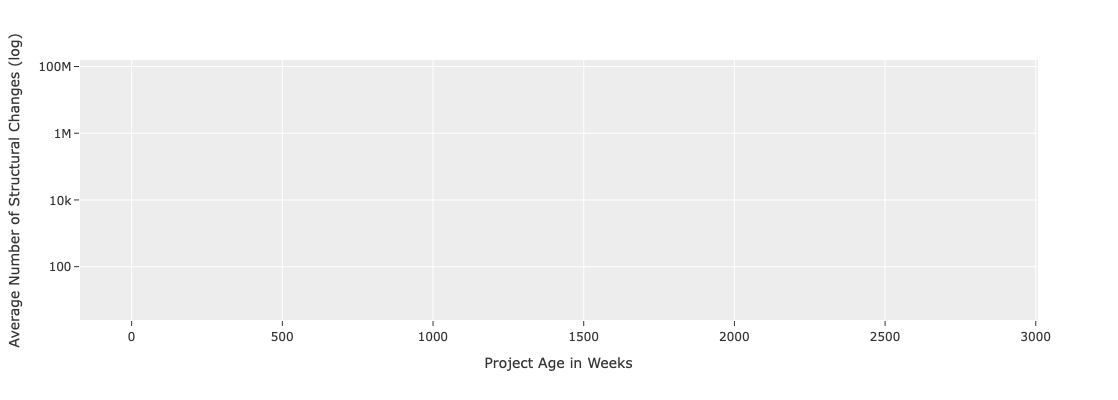

In [251]:
fig = px.scatter(df_changes_per_week, x='project_age_weeks', y='n_struc_changes', trendline="lowess", trendline_options=dict(frac=0.2))
fig.update_yaxes(type='log')

fig.update_layout(height=400, width=1000, showlegend=False, template='ggplot2')
fig.update_xaxes(title="Project Age in Weeks")
fig.update_yaxes(title="Average Number of Structural Changes (log)")
fig.update_traces(marker_color="rgb(200,25,25)")
fig.data[1].update(line_color='cyan') 

fig.show()
fig.write_image("Figures/num_struc_changes_over_weeks.pdf")

In [191]:
projects_reaching_end_at_age = ddf_commits_merged[ddf_commits_merged['project_age_weeks'] == ddf_commits_merged['project_max_age_weeks']].groupby('project_age_weeks')['repo_id'].nunique().compute()

In [206]:
projects_at_each_age = (n_projects-projects_reaching_end_at_age.sort_index().cumsum().shift(1).fillna(0).astype(int))

project_age_weeks
0       94266
1       92144
2       91535
3       91083
4       90737
        ...  
2828       10
2831        9
2834        8
2836        7
2837        3
Name: repo_id, Length: 1343, dtype: int64

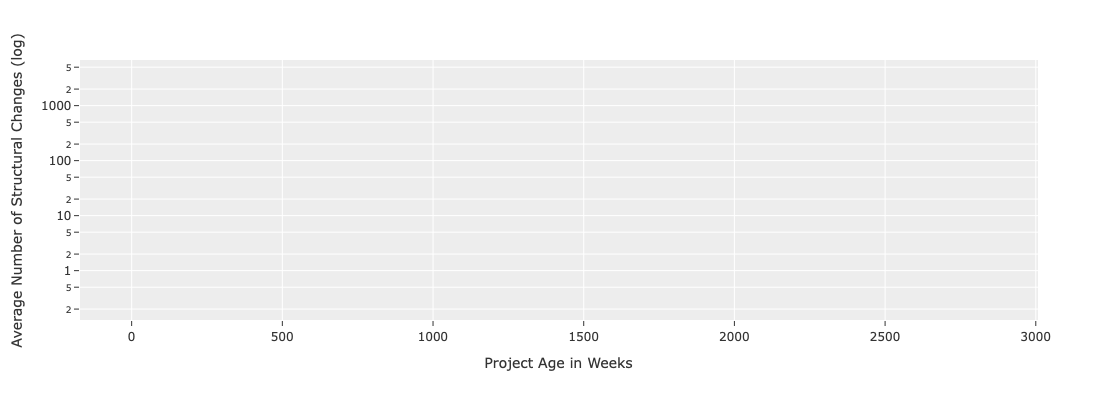

In [289]:
fig = px.scatter(x=df_changes_per_week['project_age_weeks'], y=df_changes_per_week['n_struc_changes'].div(projects_at_each_age), trendline="lowess", trendline_options=dict(frac=0.1))
fig.update_yaxes(type='log')

fig.update_layout(height=400, width=1000, showlegend=False, template='ggplot2')
fig.update_xaxes(title="Project Age in Weeks")
fig.update_yaxes(title="Average Number of Structural Changes (log)")
fig.update_traces(marker_color="rgb(200,25,25)")
fig.data[1].update(line_color='cyan') 

fig.show()
fig.write_image("Figures/num_struc_changes_over_weeks.pdf")

In [298]:
print(pd.Series(fig.data[1]['y']).to_string())

0       25.117724
1       25.042414
2       24.967264
3       24.892276
4       24.817451
5       24.742789
6       24.668290
7       24.593954
8       24.519781
9       24.445769
10      24.371918
11      24.298226
12      24.224692
13      24.151315
14      24.078093
15      24.005025
16      23.932108
17      23.859341
18      23.786722
19      23.714250
20      23.641921
21      23.569735
22      23.497689
23      23.425781
24      23.354009
25      23.282371
26      23.210864
27      23.139486
28      23.068236
29      22.997111
30      22.926109
31      22.855228
32      22.784467
33      22.713823
34      22.643295
35      22.572880
36      22.502577
37      22.432383
38      22.362297
39      22.292317
40      22.222441
41      22.152667
42      22.082994
43      22.013419
44      21.943940
45      21.874557
46      21.805266
47      21.736067
48      21.666958
49      21.597937
50      21.529002
51      21.460151
52      21.391384
53      21.322698
54      21.254091
55      21

In [275]:
df_changes_per_week['n_struc_changes'].div(projects_at_each_age).to_clipboard()

In [188]:
ddf_commits_merged.head()

,repo_id,commit_id,commit_index,commit_time,n_struc_changes,max_file_depth_diff,bucket,project_age,project_max_age,project_age_pct,project_age_rounded_pct,project_age_weeks
0,tangxiaolv_telegramgallery,54c547b14841b15364ca88c21d650812a84ca66c,0,2016-08-19 07:19:28,3.0,1.0,0,0,354,0.00,0.0,0
1,tangxiaolv_telegramgallery,bf256cc898e87efecf87bbd68466f2227319a974,1,2016-08-19 07:20:20,0.0,0.0,0,0,354,0.00,0.0,0
2,tangxiaolv_telegramgallery,e16b07582dc70995bf339be37f20b778a2f2ef2d,2,2016-08-19 10:02:35,214.0,8.0,0,0,354,0.00,0.0,0
3,tangxiaolv_telegramgallery,8f72abf8f9b9921b390c62a3d3aaeaed6846a0c6,3,2016-08-26 02:58:40,12.0,0.0,0,6,354,1.69,2.0,0
4,tangxiaolv_telegramgallery,f9b4fe607a2daacc9558e687b2712c99b1d9f264,4,2016-08-26 03:58:09,0.0,0.0,0,6,354,1.69,2.0,0


project_age_weeks
0        2122
1        2731
2        3183
3        3529
4        3847
        ...  
2828    94257
2831    94258
2834    94259
2836    94263
2837    94266
Name: repo_id, Length: 1343, dtype: int64

In [177]:
n_projects = ddf_commits_merged['repo_id'].nunique().compute()
n_projects 

94266

In [226]:
projects_at_each_age = projects_at_each_age.reindex(df_n_struc_commits_per_week['project_age_weeks'].index).fillna(method='bfill')

In [153]:
df_n_struc_commits_per_week['project_age_weeks']

0          0
1          1
2          2
3          3
4          4
        ... 
2832    1735
2833    1742
2834    1810
2835    1867
2836    2836
Name: project_age_weeks, Length: 2837, dtype: int64

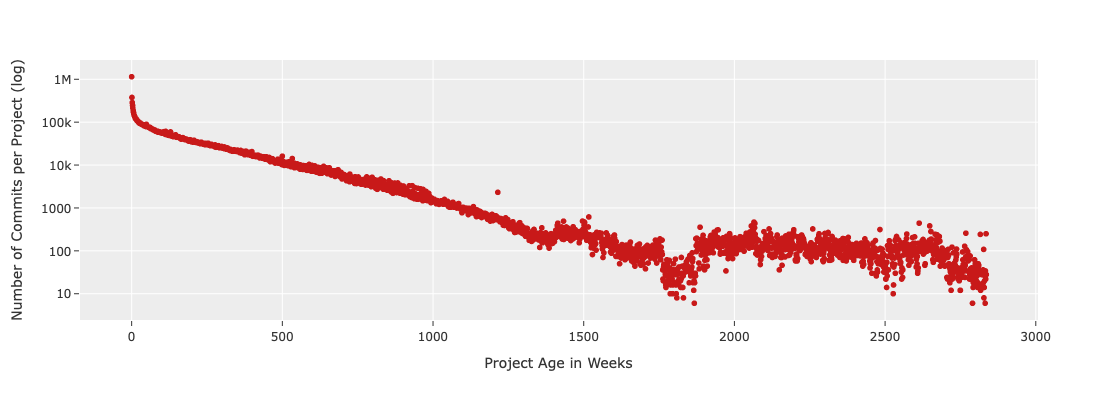

In [270]:
fig = px.scatter(x=df_n_struc_commits_per_week['project_age_weeks'], y=df_n_struc_commits_per_week['n_struc_changes'])
fig.update_yaxes(type='log')

fig.update_layout(height=400, width=1000, showlegend=False, template='ggplot2')
fig.update_xaxes(title="Project Age in Weeks")
fig.update_yaxes(title="Number of Commits per Project (log)")
fig.update_traces(marker_color="rgb(200,25,25)")

# fig.data[1].update(line_color='cyan') 

fig.show()
fig.write_image("Figures/num_struc_commits_over_weeks.pdf")

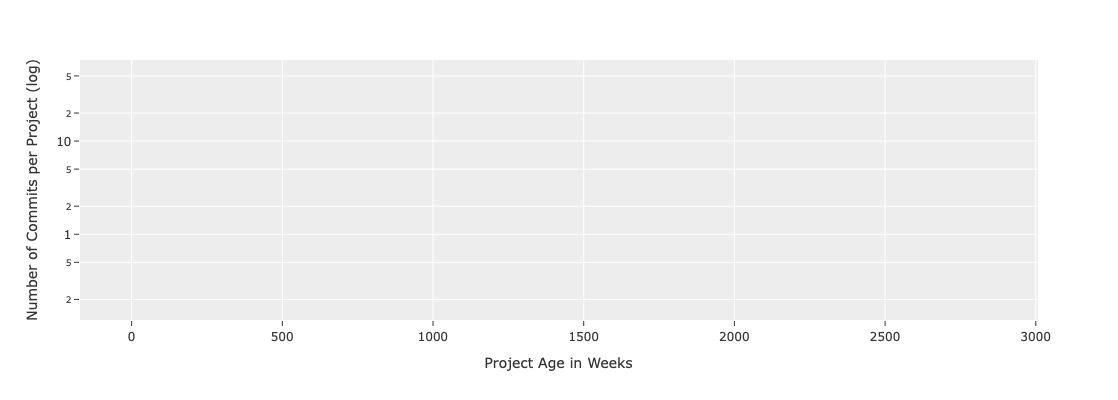

In [271]:
fig = px.scatter(x=df_n_struc_commits_per_week['project_age_weeks'], y=df_n_struc_commits_per_week['n_struc_changes'].div(projects_at_each_age))
fig.update_yaxes(type='log')

fig.update_layout(height=400, width=1000, showlegend=False, template='ggplot2')
fig.update_xaxes(title="Project Age in Weeks")
fig.update_yaxes(title="Number of Commits per Project (log)")
fig.update_traces(marker_color="rgb(200,25,25)")

# fig.data[1].update(line_color='cyan') 

fig.show()
fig.write_image("Figures/num_struc_commits_over_weeks_norm.pdf")
    

In [215]:
df_n_struc_commits_per_week['n_struc_changes'].div(projects_at_each_age)[:-1].to_clipboard()

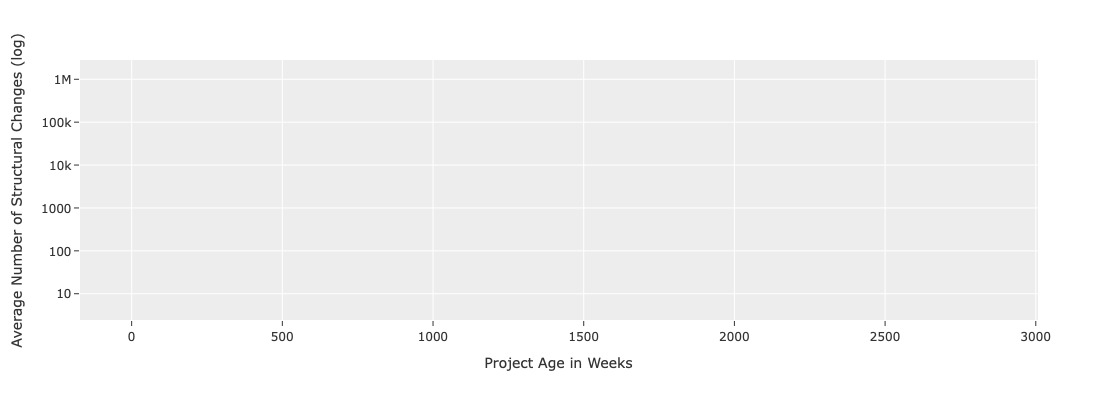

In [204]:
fig = px.scatter(x=df_n_struc_commits_per_week['project_age_weeks'], y=df_n_struc_commits_per_week['n_struc_changes'])
fig.update_yaxes(type='log')

fig.update_layout(height=400, width=1000, showlegend=False, template='ggplot2')
fig.update_xaxes(title="Project Age in Weeks")
fig.update_yaxes(title="Average Number of Structural Changes (log)")
fig.update_traces(marker_color="rgb(200,25,25)")
# fig.data[1].update(line_color='cyan') 

fig.show()
fig.write_image("Figures/num_struc_commits_over_weeks.pdf")

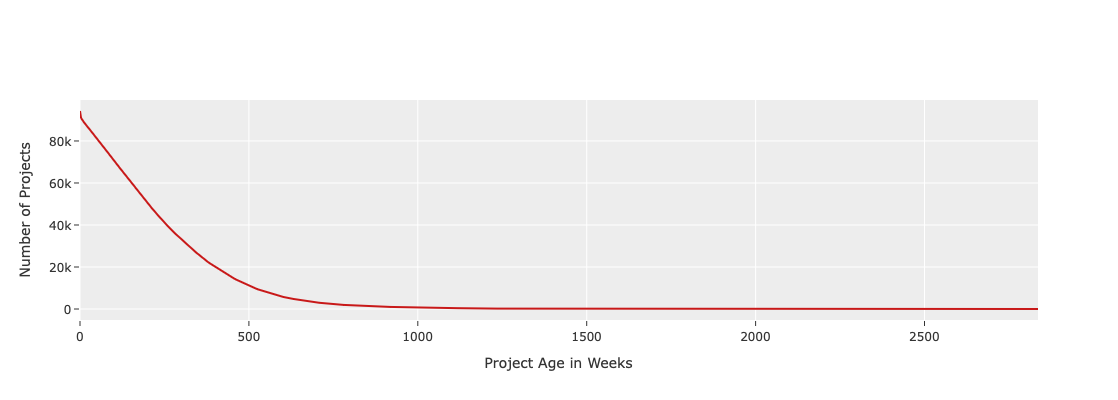

In [287]:
fig = go.Figure()
fig.add_trace(go.Line(x=projects_at_each_age.index, y=projects_at_each_age, marker_color="rgb(200,25,25)"))
fig.update_layout(height=400, width=1000, showlegend=False, template='ggplot2')
fig.update_xaxes(title="Project Age in Weeks")
fig.update_yaxes(title="Number of Projects")
fig.write_image('Figures/line_no_projects_over_age.pdf')
fig.show()

In [259]:
print(projects_at_each_age.to_string())

0       94266.0
1       92144.0
2       91535.0
3       91083.0
4       90737.0
5       90419.0
6       90142.0
7       89861.0
8       89632.0
9       89423.0
10      89192.0
11      89016.0
12      88810.0
13      88602.0
14      88405.0
15      88171.0
16      87968.0
17      87773.0
18      87575.0
19      87379.0
20      87173.0
21      86975.0
22      86782.0
23      86598.0
24      86404.0
25      86197.0
26      86007.0
27      85826.0
28      85634.0
29      85442.0
30      85231.0
31      85005.0
32      84822.0
33      84613.0
34      84404.0
35      84213.0
36      84019.0
37      83842.0
38      83670.0
39      83481.0
40      83279.0
41      83072.0
42      82846.0
43      82637.0
44      82450.0
45      82270.0
46      82036.0
47      81858.0
48      81661.0
49      81469.0
50      81266.0
51      81053.0
52      80837.0
53      80616.0
54      80403.0
55      80204.0
56      79964.0
57      79757.0
58      79536.0
59      79333.0
60      79137.0
61      78910.0
62      

# Common File Structural Changes

In [273]:
fig_data = ddf_commits['n_struc_changes'].compute()

In [ ]:
fig = px.violin(fig_data)
fig.show()

In [274]:
fig_data = df_avg_file_per_lay_pivoted.mean()
fig = px.bar(x=fig_data.index+1,y=fig_data)    
fig.add_vline(x=49, line_dash="dot", line_color="grey", line_width=2, opacity=1)

# Add an annotation explaining the break
# fig.add_annotation(
#     x=19.6, y=max(df_avg_file_per_lay_pivoted.fillna(0).mean())*0.5,
#     text="Beyond 34 no files found, except the error commits", showarrow=False, font=dict(size=12, color='grey'), textangle=-90
# )

fig.update_layout(height=400, width=1000, showlegend=False, template='ggplot2')
fig.update_xaxes(title="Depth", range=[0.5, 32.5])
fig.update_yaxes(title="Number of Files")
fig.update_traces(marker_color="rgb(200,25,25)")
fig.show()
fig.write_image('Figures/bar_overall_num_of_files_per_lay.pdf')

NameError: name 'df_avg_file_per_lay_pivoted' is not defined

#